# 1 - Beginning Workflows

In this lesson, we'll cover the basics of using atomate to run calculations. This will be a hands-on lesson where we dive into running a full workflows and break that down into components to understand how the various moving parts give us the ability to scale from 1 calculation to 10's of thousands.

In [ ]:
import mp_workshop.atomate

In [ ]:
!pmg config -a MAPI_KEY <MAPI_KEY>

# Building a workflow

To begin, we'll start by grabbing a structure from materials project using pymatgen and the MPRester interface we learned about in a previous course

In [ ]:
from pymatgen import MPRester

mpr = MPRester()

struc = mpr.get_structure_by_material_id("mp-27")
print(struc)

Now, let's construct a workflow using atomate to optimize this structure in DFT

In [ ]:
from atomate.vasp.workflows.presets.core import wf_structure_optimization

In [ ]:
wf = wf_structure_optimization(struc,{"DB_FILE": "/home/jovyan/mp_workshop/fireworks_config/db.json"})
print(wf)

Get some more information on the workflow

In [ ]:
wf.as_dict()

# Running with Fake VASP to simulate a DFT calculation

Due to a combination of licensing issues and just not being able to run this quickly on the jupyter server, we're going to simulate VASP running with a magic function. You will later learn about powerups, which let you modify a workflow. For this exercise we're going to use a powerup that will replace the normal VASP running functionality with something that just copies files we've prepared for you

In [ ]:
from atomate.vasp.powerups import use_fake_vasp

## Lets do some work to get the path to fake VASP files

In [ ]:
from mp_workshop.atomate import si_struct_opt_path

print(si_struct_opt_path)

In [ ]:
wf = use_fake_vasp(wf, ref_dirs={"Si-structure optimization": si_struct_opt_path})
wf.as_dict()

## Now we have to get ourself a LaunchPad so that we can submit this workflow to our database


Atomate uses Fireworks as its workflow engine. Fireworks hides the database with an object called a LaunchPad. This allows you to submit and query workflows from anywhere you have database access. We need to get ourselves a LaunchPad object so we can submit our workflow

### Open a fireworks session 

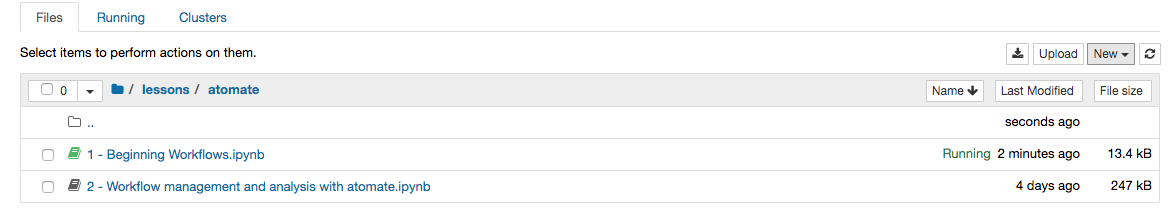

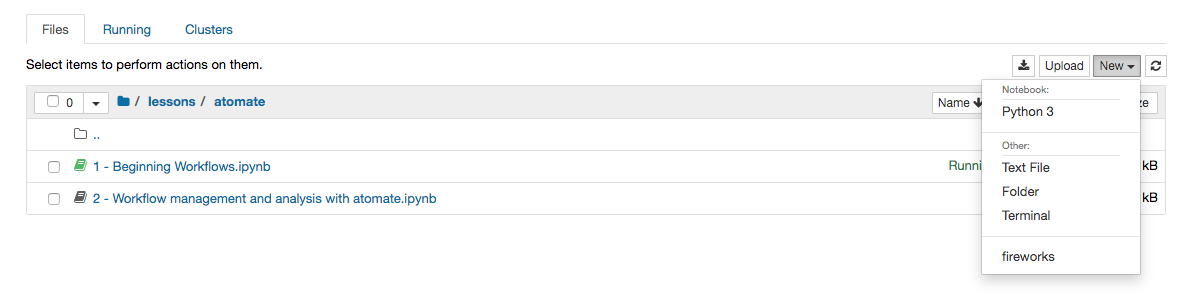

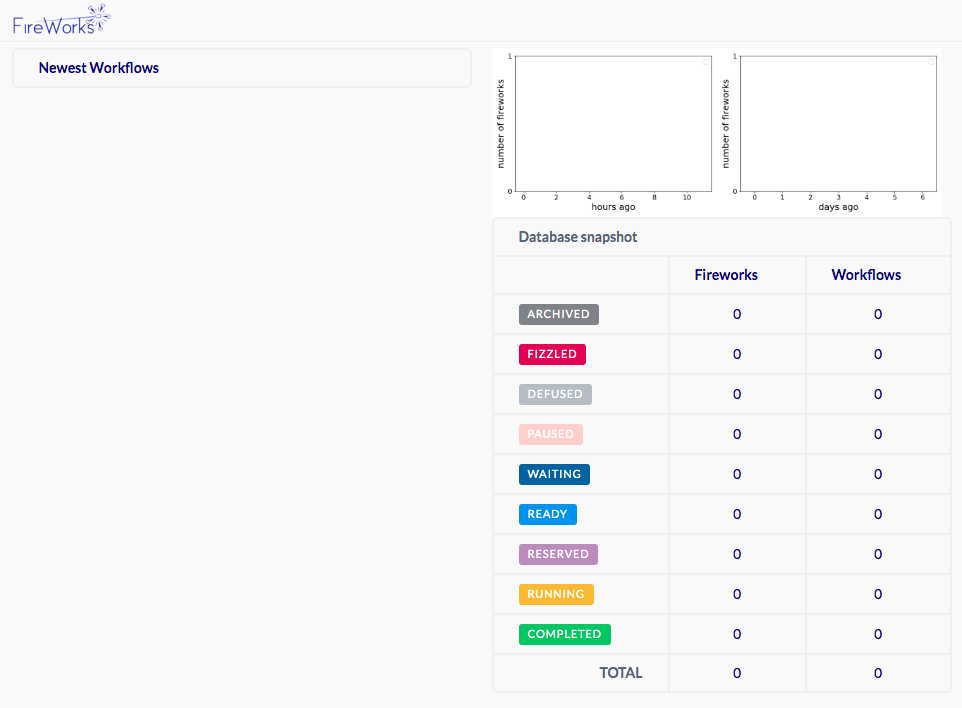

In [ ]:
from fireworks.core.launchpad import LaunchPad

lp = LaunchPad.auto_load()

For this one time, we have to initialize the database. In everyday use, we'll only do this once. For this lesson, we'll use it a few times:

In [ ]:
lp.reset(None,require_password=False)

We can use the launchpad to add a workkflow to our database:

In [ ]:
lp.add_wf(wf)

# Monitoring Workflows

Fireworks lets you monitor the status of workflows and fireworks using both python and the command line. Let's start off by looking at the status of our workflow. For each bit of python code, i'll include a cell with a command line command using jupyter-notebook's '!' functionality. In practice, we use the command line tools quite a bit and will be emphasized in this notebook.

**Command Line Access in Jupyter**: Jupyter lets you running command line commands by prefacing them with the exclamation mark:

In [ ]:
# Lets get workflows

def get_wflows():
    for wf_id in lp.get_wf_ids():
        for key,value in lp.get_wf_summary_dict(wf_id).items():
            print(key, ": ",value)
        print("\n")

get_wflows()

This is how you get workflow information on the command line

In [ ]:
!lpad get_wflows

In [ ]:
def get_fws():
    for fw_id in lp.get_fw_ids():
        fw = lp.get_fw_dict_by_id(fw_id)
        for prop in ["fw_id","updated_on","state","name"]:
            print(prop, ": ",fw[prop])

        print("\n")
        
get_fws()

This command line gets you the same information

In [ ]:
!lpad get_fws

In [ ]:
!lpad --help

In [ ]:
# Let's look at what this command can do:
!lpad get_fws --help

# Now lets run this workflow


There are a few different ways to run a workflow. The first is to just run it within this notebook directly.

In [ ]:
from fireworks.core.rocket_launcher import launch_rocket

In [ ]:
# Lets move into a temporary working directory
import os

os.mkdir("temp")
os.chdir("temp")

In [ ]:
launch_rocket(lp)

Now, lets see how that changed our fireworks

In [ ]:
!lpad get_fws

This let me run a single firework in the notebook. What if I wanted to run multiple fireworks? First lets reset the old firework and add some more workflows to our database

In [ ]:
# We can do the same thing using the command line:
!lpad rerun_fws 

In [ ]:
!lpad get_fws

In [ ]:
# Let's add the workflow a few more times to have multiple fireworks in database
lp.add_wf(wf)
lp.add_wf(wf)

We can run all of the available fireworks using a 2 lines of python and a single command:

In [ ]:
from fireworks.core.rocket_launcher import rapidfire
rapidfire(lp)

This let us run fireworks until we no longer had any to run. But we're still running fireworks in our jupyter notebook. If I want to run on this on another machine I need to do something else. Normally, we would want to launch these jobs to our supercomputing queue and let that run them as resources become available. 

### Using the queue launcher:

Setting up the queue launcher unfortunately takes some work. There are configuration files to tell atomate how to submit jobs, where the database is and what special parameters to use for this supercomputer. 

This has all been setup for you in this workshop. Once setup, to use the queue, we simply launch the fireworks to the queue.

Lets start off by clearing the database of fireworks

In [ ]:
lp.reset(None,require_password=False)

In [ ]:
from atomate.vasp.workflows.presets.core import wf_bandstructure

wf = wf_bandstructure(struc,{"DB_FILE": "/home/jovyan/mp_workshop/fireworks_config/db.json"})
wf.as_dict()

In [ ]:
from mp_workshop.atomate import si_static_path,si_nscf_line_path,si_nscf_uniform_path
wf = use_fake_vasp(wf,{"Si-structure optimization":si_struct_opt_path,
                       "Si-static": si_static_path,
                       "Si-nscf uniform" : si_nscf_uniform_path,
                       "Si-nscf line": si_nscf_line_path})

lp.add_wf(wf)

In [ ]:
!lpad get_fws

Fireworks has a commmand line method to submit jobs to the SLURM queue:

In [ ]:
!qlaunch -r rapidfire --nlaunches 1

Now, the supercomputer will take care of running the jobs and eventually we can test to see that they are working

In [ ]:
!lpad get_fws

Now lets have qlaunch submit fireworks until all are done.

In [ ]:
!qlaunch -r rapidfire

In [ ]:
!lpad get_fws

### Now, we have a completed workflow 